# Assignment 11- Loan Default RF with SHAP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as stats
import plotly.io as pio
pio.renderers.default = "notebook"

In [2]:
#read data
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df_dict = pd.read_excel('Variables_Dictionary_2019.xlsx')

# 1. Data Preparation

In [3]:
#Transform the values into numeric format before plotting and working analysis
#df = df.apply(pd.to_numeric, errors='coerce') 

#clean the variable dictionary data
df_dict = df_dict.drop(df_dict.columns[0], axis=1)
df_dict = df_dict.drop(df_dict.index[:3])
df_dict.columns = ['NO.', 'Var', 'dtypes', 'description', 'Var_Category']

#drop first 3 and empty columns
df1 = df.drop(df.columns[:3], axis=1)
columns_to_drop = ['TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062']
df1 = df1.drop(columns=columns_to_drop)

#Transform date format
df1['AP005'] = pd.to_datetime(df1['AP005'], format='%Y/%m/%d %H:%M').dt.strftime('%Y-%m-%d %H:%M:%S')
df1.head()

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,31,2,1,12,2017-07-06 10:21:00,ios,3,3,1,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,0,27,1,1,12,2017-04-06 12:51:00,h5,5,4,0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,0,33,1,4,12,2017-07-01 14:11:00,h5,4,2,0,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,0,34,2,4,12,2017-07-07 10:10:00,android,5,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,0,47,2,1,12,2017-07-06 14:37:00,h5,4,4,1,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [4]:
#Encode categorical values
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['AP006', 'MB007']:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le  # store the label encoder for potential inverse transformation later

#df1 column name references the variable dictionary by joining the content and if NaN keep the original column name
df1.columns = df1.columns.map(lambda col: df_dict.set_index('Var').loc[col, 'description'] if col in df_dict['Var'].values else col)
df1.columns.values[0] = 'Loan_Default'

#Change the last column name to tech_gadget
df1.columns = list(df1.columns[:-1]) + ['tech_gadget']
df1.head()

#change the target column to categorical column
df1['Loan_Default'] = df1['Loan_Default'].astype('category')


In [5]:
print(df1.columns)

Index(['Loan_Default', 'YR_AGE', 'CODE_GENDER', 'CODE_EDUCATION', 'LOAN_TERM',
       'DATE_APPLIED', 'OS_TYPE', 'LEVEL_APPL_CITY',
       'FLAG_IP_CITY_NOT_APPL_CITY', 'AP009', 'TD_CNT_QUERY_LAST_7Day_P2P',
       'TD_CNT_QUERY_LAST_7Day_SMALL_LOAN', 'TD_CNT_QUERY_LAST_1MON_P2P',
       'TD_CNT_QUERY_LAST_1MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_3MON_P2P',
       'TD_CNT_QUERY_LAST_3MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_P2P',
       'TD_CNT_QUERY_LAST_6MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_BANK',
       'TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'CNT_QUERY_TIME_LAST_1MON', 'CNT_QUERY_TIME_LAST_2MON',
       'AMT_LOAN_TOTAL', 'FLAG_CREDIT_CARD_ACCT_OVER_8',
       'MONTH_CREDIT_CARD_MOB_MAX', 'SCORE_DEBIT_CARD_TOTAL_AMT',
       'SCORE_DEBIT_CARD_UTILITY_AMT', 'SCORE_SINGLE_DEBIT_CARD_LIMIT',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL',
       'AVG_LEN_COLLECTION_OR_H

In [6]:
#drop the NaN values
df1 = df1.dropna()

In [7]:
#check if df1 has missing values
missing_values = df1.isnull().any().any()

missing_values

False

# 2. Modeling with Variables

In [8]:
features = ['YR_AGE', 'CODE_GENDER', 'CODE_EDUCATION', 'LOAN_TERM',
       'DATE_APPLIED', 'OS_TYPE', 'LEVEL_APPL_CITY',
       'FLAG_IP_CITY_NOT_APPL_CITY', 'AP009', 'TD_CNT_QUERY_LAST_7Day_P2P',
       'TD_CNT_QUERY_LAST_7Day_SMALL_LOAN', 'TD_CNT_QUERY_LAST_1MON_P2P',
       'TD_CNT_QUERY_LAST_1MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_3MON_P2P',
       'TD_CNT_QUERY_LAST_3MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_P2P',
       'TD_CNT_QUERY_LAST_6MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_BANK',
       'TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'CNT_QUERY_TIME_LAST_1MON', 'CNT_QUERY_TIME_LAST_2MON',
       'AMT_LOAN_TOTAL', 'FLAG_CREDIT_CARD_ACCT_OVER_8',
       'MONTH_CREDIT_CARD_MOB_MAX', 'SCORE_DEBIT_CARD_TOTAL_AMT',
       'SCORE_DEBIT_CARD_UTILITY_AMT', 'SCORE_SINGLE_DEBIT_CARD_LIMIT',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL',
       'AVG_LEN_COLLECTION_OR_HIGH_RISK_CALLS',
       'AVG_LEN_COLLECTION_OR_HIGH_RISK_INBOUND_CALLS',
       'AVG_LEN_COLLECTION_OR_HIGH_RISK_OUTBOUND_CALLS',
       'AVG_LEN_COLLECTION_CALLS', 'LEN_TOTAL_INBOUND_CALLS_LAST_1MON',
       'CNT_TOTAL_OUTBOUND_CALLS_LAST_3MON',
       'CNT_FAMILY_INBOUND_CALLS_LAST_3MON',
       'CNT_FAMILY_OUTBOUND_CALLS_LAST_3MON', 'CNT_COLLEAGUE_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_CALLS_LAST_2MON',
       'CNT_ABNORMAL_HOURS_INBOUND_CALLS_LAST_2MON',
       'CNT_ABNORMAL_HOURS_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_INBOUND_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_OUTBOUND_CALLS_LAST_3MON',
       'CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_2MON',
       'CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_3MON',
       'CNT_DISTINCT_CALLS_LAST_1MON', 'CNT_DISTINCT_OUTBOUND_CALLS_LAST_1MON',
       'CNT_DISTINCT_CALLS_LAST_2MON', 'CNT_DISTINCT_OUTBOUND_CALLS_LAST_2MON',
       'CNT_DISTINCT_CALLS_LAST_3MON', 'CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_2MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON',
       'CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON',
       'CNT_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON',
       'LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON',
       'LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON',
       'CNT_SERVICE_OUTBOUND_CALLS_LAST_2MON', 'CNT_SERVICE_CALLS_LAST_3MON',
       'CNT_SERVICE_OUTBOUND_CALLS_LAST_3MON', 'LEN_SERVICE_CALLS_LAST_1MON',
       'LEN_SERVICE_OUTBOUND_CALLS_LAST_1MON', 'LEN_SERVICE_CALLS_LAST_2MON',
       'LEN_SERVICE_OUTBOUND_CALLS_LAST_2MON', 'LEN_SERVICE_CALLS_LAST_3MON',
       'LEN_SERVICE_OUTBOUND_CALLS_LAST_3MON', 'YR_PHONE_ACTIVE',
       'tech_gadget']

target = 'Loan_Default'

In [9]:
#convert the date to non string format
df1['DATE_APPLIED'] = pd.to_datetime(df1['DATE_APPLIED']).astype(np.int64) // 10**9

#cross validation
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df1[features],
                                                    df1[target], 
                                                    random_state=1234, 
                                                    stratify=df1[target])

In [10]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
#the optimal max_depth from before modelling since it is the only exists in sklearn's RandomForestRegressor
optimal_params = {'max_depth': 23}

#convert and round parameters to appropriate datatype
optimal_params['max_depth'] = int(round(optimal_params['max_depth']))

#define the model
rf = RandomForestRegressor(**optimal_params, random_state=0, n_estimators=20)

rf.fit(X_train, Y_train)

#get importance of features
importances = rf.feature_importances_
importances_df = pd.DataFrame(importances, columns=['importance'])
importances_df['feature'] = X_train.columns

print(importances_df)


    importance                               feature
0     0.024619                                YR_AGE
1     0.002737                           CODE_GENDER
2     0.015025                        CODE_EDUCATION
3     0.014783                             LOAN_TERM
4     0.039194                          DATE_APPLIED
..         ...                                   ...
73    0.014624  LEN_SERVICE_OUTBOUND_CALLS_LAST_2MON
74    0.016013           LEN_SERVICE_CALLS_LAST_3MON
75    0.014154  LEN_SERVICE_OUTBOUND_CALLS_LAST_3MON
76    0.020380                       YR_PHONE_ACTIVE
77    0.015197                           tech_gadget

[78 rows x 2 columns]


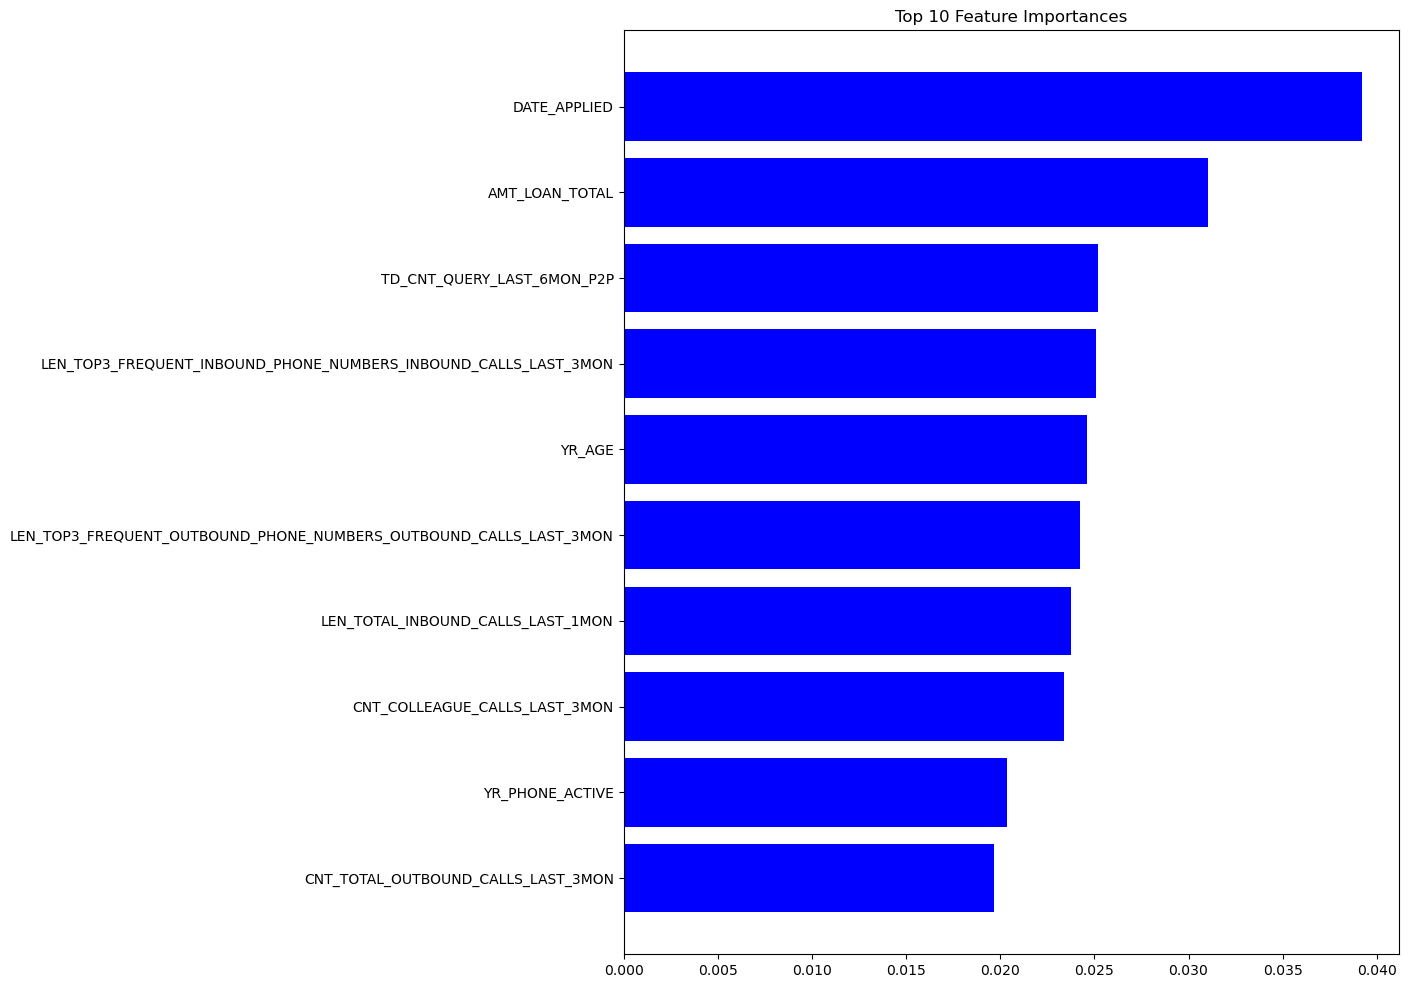

In [11]:
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Get top 10 features and their importance
top_features = importances_df['feature'][:10]
top_importance_values = importances_df['importance'][:10]

# Plot
plt.figure(figsize=(10,12))
plt.title("Top 10 Feature Importances")
plt.barh(top_features, top_importance_values, color="b", align="center")
plt.gca().invert_yaxis()
plt.show()

## SHAP 
1. Explains individual predictions made by machine learning models
2. Provides a uniform measure of feature importance and makes it possible to interpret model predictions consistently
3. Fairly distributes each feature's "contribution" to all potential predictions
4. Guarantees consistent interpretation regardless of the complexity of the model and describes how features affect specific predictions for local interpretability


### SHAP summary plot

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


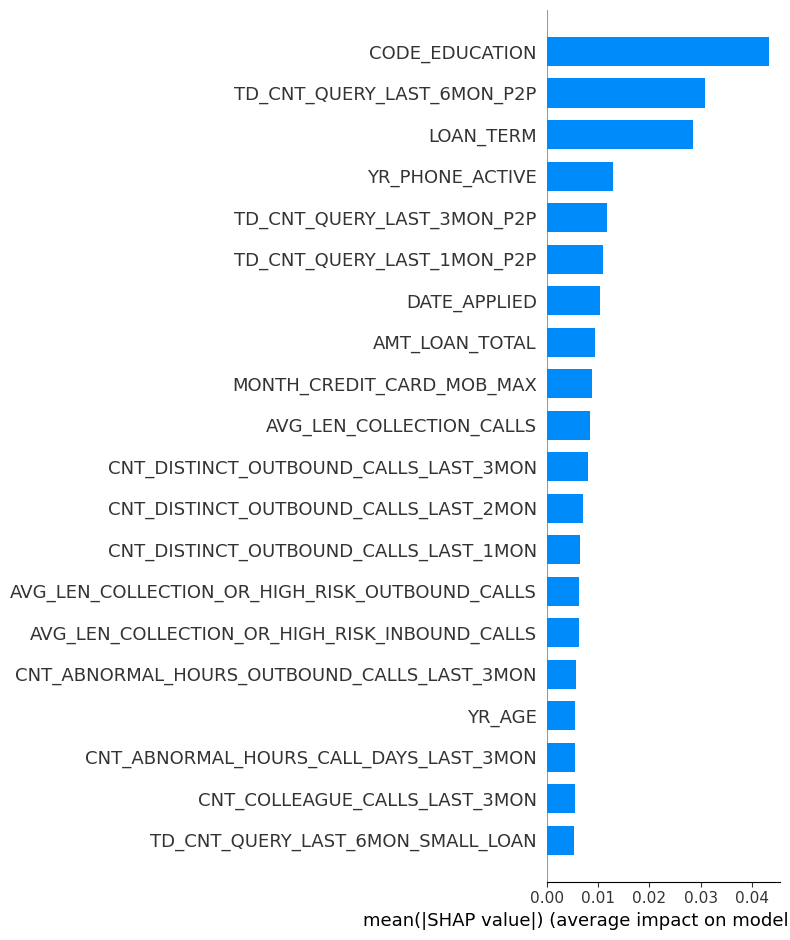

In [12]:
from tqdm import tqdm
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

The top 3 features contribute the highest predictive power over mean absolute shap value 0.2 towards the random forest model are code education, total count query last 6 months p2p, and loan term. The next two higher features are year phone active and count query last 3 months p2p. Whilst total count query last 6 months with small loan presents the lowest predictive power amongst the top 10 important features. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


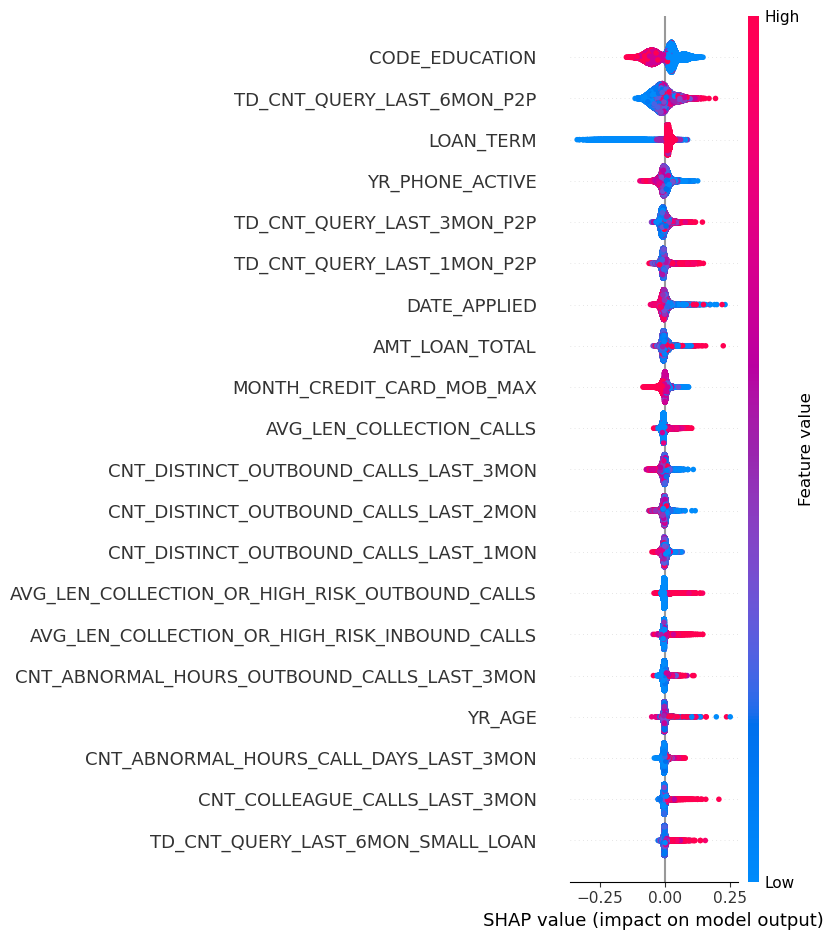

In [13]:
#plot the positive and negative relationships of the predictors with the target variable
shap.summary_plot(shap_values, X_train)

The feature importance is ranked in descending orders so the higher the location is, the higher prediction could be. The color distinguishes high predictive variable in red and low predictive variable in blue. The code education and year phone active features are negatively correlated to the target variable whereas total count query in last 6 months p2p, loan term, and td count query last 3 months p2p variables show positive impact on detecting the mortgage loan fraud. 

### SHAP dependence plot
**the marginal effect of one or two features on the predicted outcome of a machine learning model**

In [14]:
pd.set_option('display.max_colwidth', None)
importances_df['feature'][:10]

4                                                          DATE_APPLIED
28                                                       AMT_LOAN_TOTAL
15                                           TD_CNT_QUERY_LAST_6MON_P2P
66      LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON
0                                                                YR_AGE
65    LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON
40                                    LEN_TOTAL_INBOUND_CALLS_LAST_1MON
44                                        CNT_COLLEAGUE_CALLS_LAST_3MON
76                                                      YR_PHONE_ACTIVE
41                                   CNT_TOTAL_OUTBOUND_CALLS_LAST_3MON
Name: feature, dtype: object

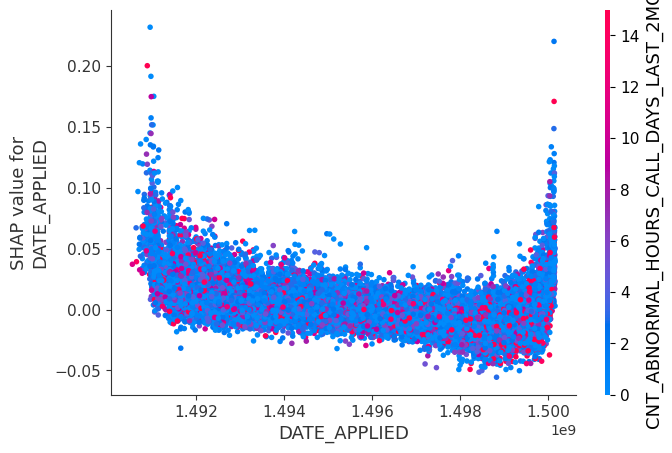

In [16]:
shap.dependence_plot('DATE_APPLIED', shap_values, X_train)

The plot shows there might be a slightly negative trend between date applied and target variable.

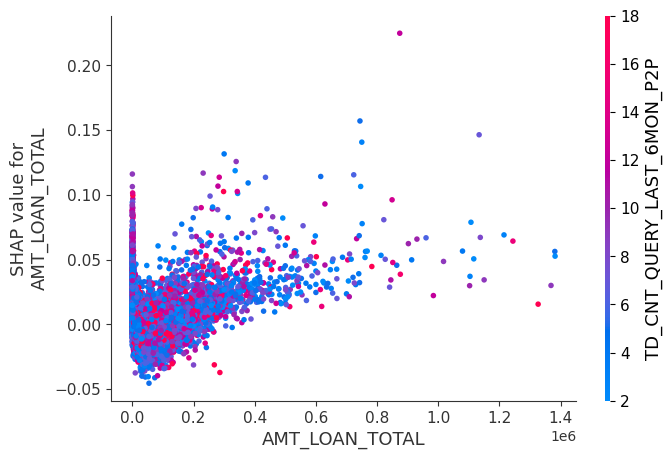

In [17]:
shap.dependence_plot('AMT_LOAN_TOTAL', shap_values, X_train)

The total loan amount displays a positive relationship to target variable while the shap values are almost in a range between -0.05 and 0.15.

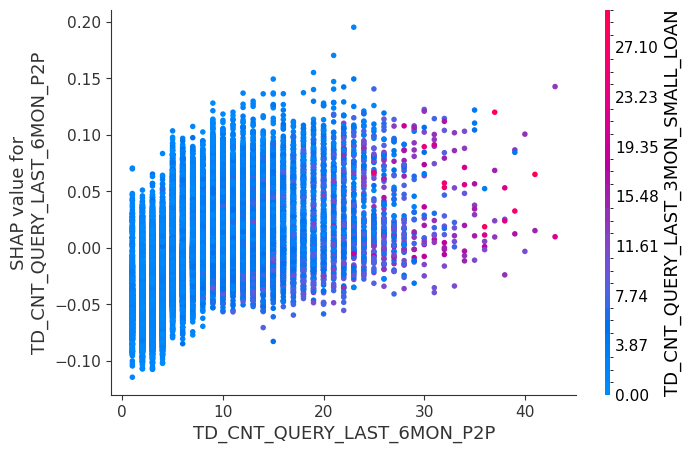

In [18]:
shap.dependence_plot('TD_CNT_QUERY_LAST_6MON_P2P', shap_values, X_train)

TD count query last 6 months p2p feature shows a roughly positive relationship towards load default variable

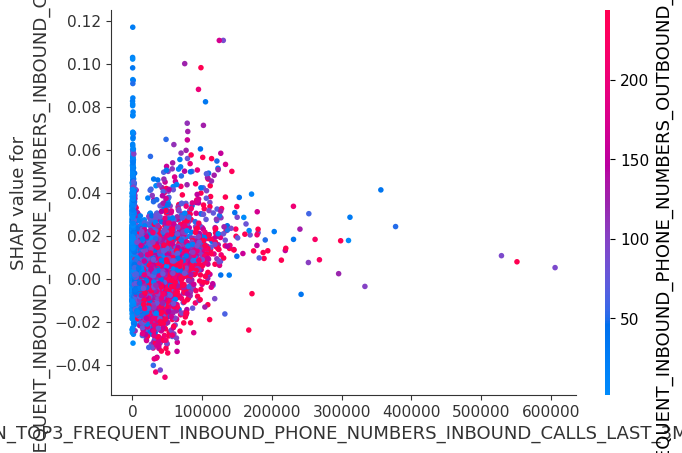

In [19]:
shap.dependence_plot('LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON', shap_values, X_train)

This feature might have little positive relationship with target variable since the scatters are located at the bottom left corner intensively

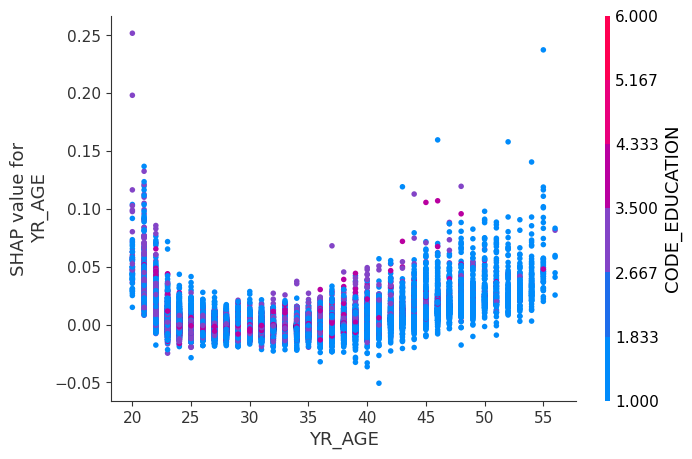

In [20]:
shap.dependence_plot('YR_AGE', shap_values, X_train)

Year age feature might have subtle positive relationship with target values.

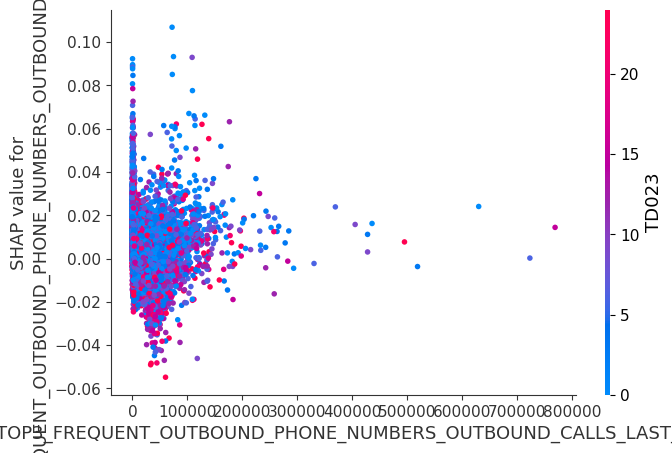

In [21]:
shap.dependence_plot('LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON', shap_values, X_train)

This feature does not demonstrate an apparent relationship with target values

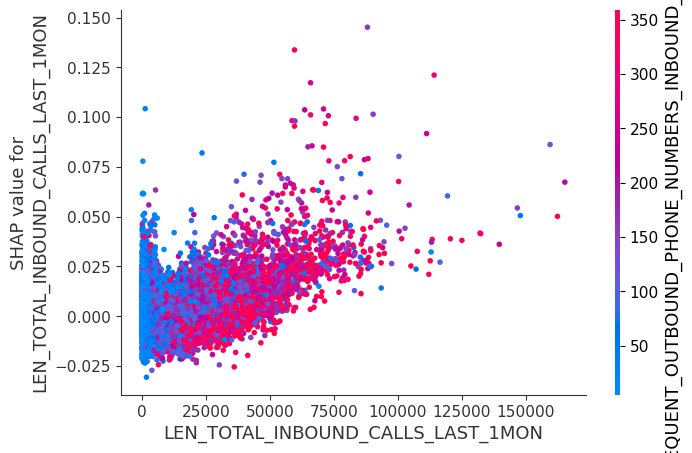

In [22]:
shap.dependence_plot('LEN_TOTAL_INBOUND_CALLS_LAST_1MON', shap_values, X_train)

Len total inbound calls last 1 month shows a positive linear relationship with loan default values.

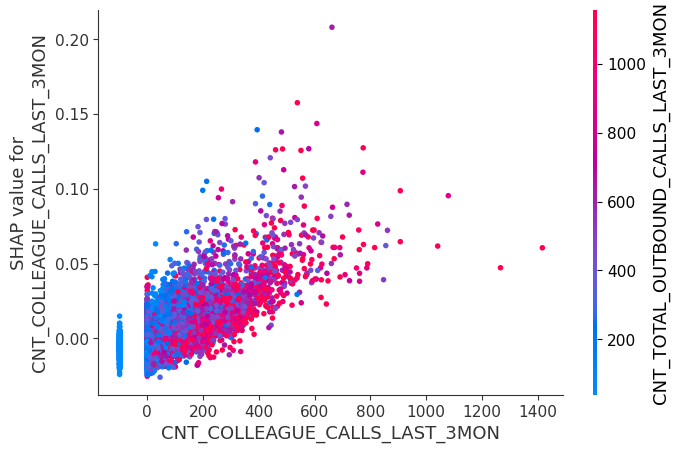

In [23]:
shap.dependence_plot('CNT_COLLEAGUE_CALLS_LAST_3MON', shap_values, X_train)

Count colleague calls last 3 months shows a positive linear trend to loan default variable

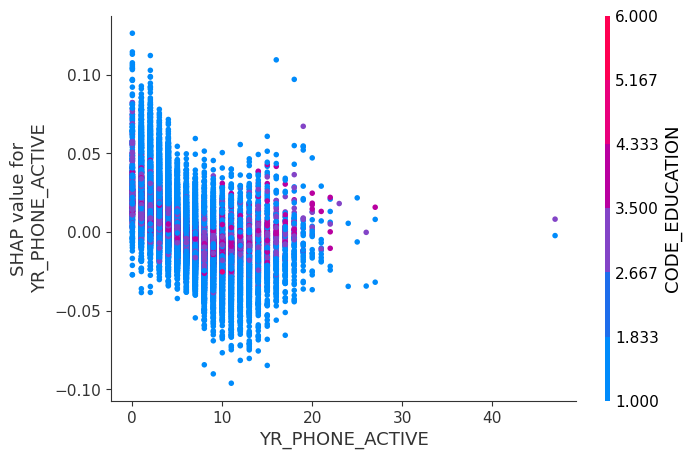

In [24]:
shap.dependence_plot('YR_PHONE_ACTIVE', shap_values, X_train)

year phone active shows a general downard trend to the loan default values

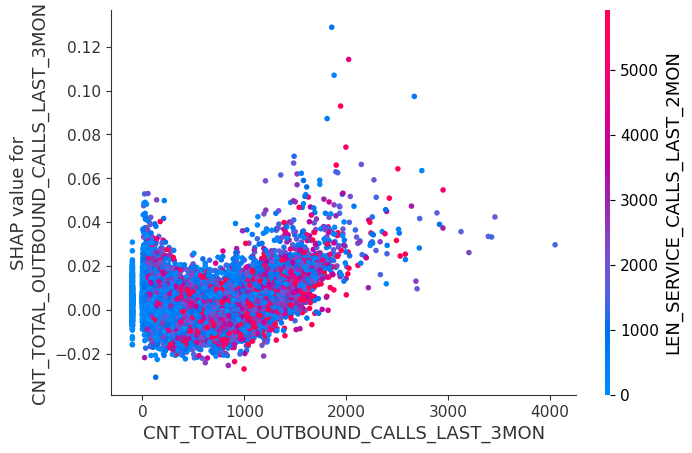

In [25]:
shap.dependence_plot('CNT_TOTAL_OUTBOUND_CALLS_LAST_3MON', shap_values, X_train)

The feature shows a convexed trend with loan default values

### SHAP individual value plot - local interpretability

In [34]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(rf.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,330,50) # Every 50 rows
S = X_output.iloc[random_picks]
S

,YR_AGE,CODE_GENDER,CODE_EDUCATION,LOAN_TERM,DATE_APPLIED,OS_TYPE,LEVEL_APPL_CITY,FLAG_IP_CITY_NOT_APPL_CITY,AP009,TD_CNT_QUERY_LAST_7Day_P2P,...,CNT_SERVICE_OUTBOUND_CALLS_LAST_3MON,LEN_SERVICE_CALLS_LAST_1MON,LEN_SERVICE_OUTBOUND_CALLS_LAST_1MON,LEN_SERVICE_CALLS_LAST_2MON,LEN_SERVICE_OUTBOUND_CALLS_LAST_2MON,LEN_SERVICE_CALLS_LAST_3MON,LEN_SERVICE_OUTBOUND_CALLS_LAST_3MON,YR_PHONE_ACTIVE,tech_gadget,predict
77914,28,1,1,12,1499630940,2,3,3,1,2,...,1.0,2576.0,2576.0,2576.0,2576.0,2579.0,2576.0,3.0,101,0.45
45035,54,2,1,12,1496929020,0,5,5,1,2,...,8.0,206.0,175.0,286.0,255.0,989.0,958.0,9.0,98,0.16
33491,30,2,1,12,1496485260,2,2,2,1,2,...,3.0,529.0,492.0,529.0,492.0,564.0,492.0,3.0,101,0.23
75379,29,1,4,12,1494844020,3,5,3,0,2,...,46.0,3772.0,3367.0,5125.0,4720.0,5475.0,4970.0,5.0,46,0.06
44197,26,1,3,12,1498762440,3,3,3,1,2,...,3.0,24.0,0.0,203.0,179.0,203.0,179.0,7.0,44,0.06
38780,31,2,3,12,1497285240,2,5,5,1,1,...,3.0,0.0,0.0,33.0,0.0,33.0,0.0,7.0,101,0.06
39545,41,2,1,12,1494083880,1,5,5,1,2,...,1.0,0.0,0.0,201.0,201.0,201.0,201.0,10.0,73,0.35


In [28]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [29]:
shap_plot(0)

The output value is 0.45 and the average prediction of the dataset is 0.21, which year phone active, loan term, len service outbound calls last 2 months, and code education features push the prediction higher while count distinct outbound calls last 1 month feature lowers the prediction.

In [30]:
shap_plot(1)

The output value is 0.16 and the average prediction of the dataset is roughly 0.21, which credit card mob max, code education, and year age features push the prediction higher while count distinct outbound calls last 3 months, year phone active, and tdcount query features lower the prediction.

In [35]:
shap_plot(2)

The output value is 0.23 and the average prediction of the dataset is 0.21, which inbound calls last 3 month, year phone active, loan term, and code education features push the prediction higher while count distinct outbound calls and td count query last 6 months p2p features lower the prediction.

In [32]:
shap_plot(3)

The output value is 0.06 and the average prediction of the dataset is 0.21, which outbound calls last 1 month and TD024 features push the prediction higher while count distinct outbound calls last 3 months, code education, and avergae len collection calls features lower the prediction.